This is the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import celltypist
from celltypist import models

import os

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

## download celltypist models
# get the low-immune (low-level on ontology, high-resolution)
model_str = 'Immune_All_Low.pkl'
models.download_models(model = [model_str])



📂 Storing models in /beevol/home/davidson/.celltypist/data/models
⏩ Skipping [1/9]: Immune_All_Low.pkl (file exists)
⏩ Skipping [2/9]: Immune_All_High.pkl (file exists)
⏩ Skipping [3/9]: Immune_All_PIP.pkl (file exists)
⏩ Skipping [4/9]: Immune_All_AddPIP.pkl (file exists)
⏩ Skipping [5/9]: Cells_Intestinal_Tract.pkl (file exists)
⏩ Skipping [6/9]: Cells_Lung_Airway.pkl (file exists)
⏩ Skipping [7/9]: Developing_Mouse_Brain.pkl (file exists)
⏩ Skipping [8/9]: Nuclei_Lung_Airway.pkl (file exists)
⏩ Skipping [9/9]: Pan_Fetal_Human.pkl (file exists)
📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json


scanpy==1.8.2 anndata==0.7.8 umap==0.5.2 numpy==1.19.5 scipy==1.7.1 pandas==1.3.3 scikit-learn==1.0 statsmodels==0.13.0 python-igraph==0.9.8 louvain==0.7.1 pynndescent==0.5.5


📚 Total models in list: 9
📂 Storing models in /beevol/home/davidson/.celltypist/data/models
💾 Downloading model [1/9]: Immune_All_Low.pkl
💾 Downloading model [2/9]: Immune_All_High.pkl
💾 Downloading model [3/9]: Immune_All_PIP.pkl
💾 Downloading model [4/9]: Immune_All_AddPIP.pkl
💾 Downloading model [5/9]: Cells_Intestinal_Tract.pkl
💾 Downloading model [6/9]: Cells_Lung_Airway.pkl
💾 Downloading model [7/9]: Developing_Mouse_Brain.pkl
💾 Downloading model [8/9]: Nuclei_Lung_Airway.pkl
💾 Downloading model [9/9]: Pan_Fetal_Human.pkl


## Open files

In [2]:
data_path = f"{os.getcwd()}/../../data/single_cell_data/pbmc6k/hg19/"

results_file = f"{data_path}/pbmc6k.h5ad"

adata = sc.read_10x_mtx(
    data_path,                               # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`


... reading from cache file cache/beevol-home-davidson-checkouts-sc_bulk_ood-evaluation_experiments-pbmc6k-..-..-data-single_cell_data-pbmc6k-hg19-matrix.h5ad


In [3]:
# make cell type specific marker annotation

genes_annot_dict = {
    'CD14': ['CD14 (CD14 Mono)'],
    'LYZ': ['LYZ (CD14 Mono)'],
    'FCGR3A': ['FCGR3A (CD16 Mono)'],
    'MS4A7': ['MS4A7 (CD16 Mono)'],
    'FCER1A': ['FCER1A (Dendritic)'],
    'CST3': ['CST3 (Dendritic)'],
    'GNLY': ['GNLY (NK)'],
    'NKG7': ['NKG7 (NK)'],
    'MS4A1': ['MS4A1 (B cell)'],
    'CD79A': ['CD79A (B cell)'],
    'IL7R': ['IL7R (CD4T)'],
    'CCR7': ['CCR7 (Naive CD4T)'],
    'S100A4': ['S100A4 (Memory CD4T)'],
    'CD8A': ['CD8A (CD8 T)'],
    'PPBP': ['PPBP (Megak)']
}



# Initialize empty column in cell metadata
adata.var['gene_annot'] = adata.var_names

# Generate new assignments
for i in genes_annot_dict.keys():
    ind = np.where(pd.Series(adata.var_names).isin([i]))[0]
    adata.var['gene_annot'].iloc[ind] = genes_annot_dict[i]
adata.var['gene_annot'].iloc[ind]

PPBP    PPBP (Megak)
Name: gene_annot, dtype: object

## Preprocessing

In [4]:
# lets see whats in adata
adata

AnnData object with n_obs × n_vars = 5419 × 32738
    var: 'gene_ids', 'gene_annot'

normalizing counts per cell
    finished (0:00:00)


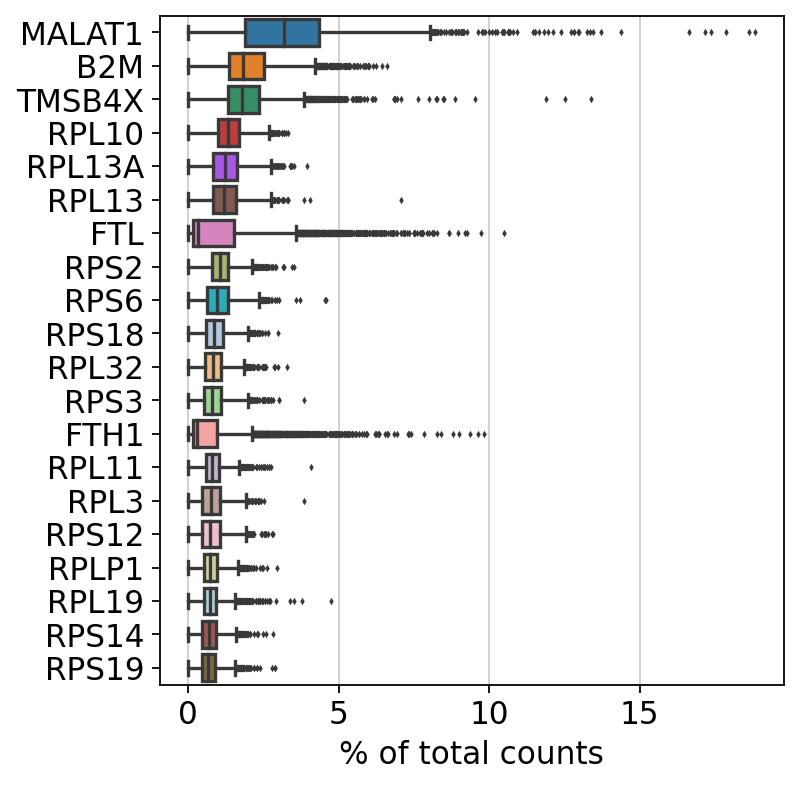

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [6]:
# filter out cells with less than 200 genes and genes expressed in less than 3 cells
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1 cells that have less than 200 genes expressed
filtered out 18395 genes that are detected in less than 3 cells


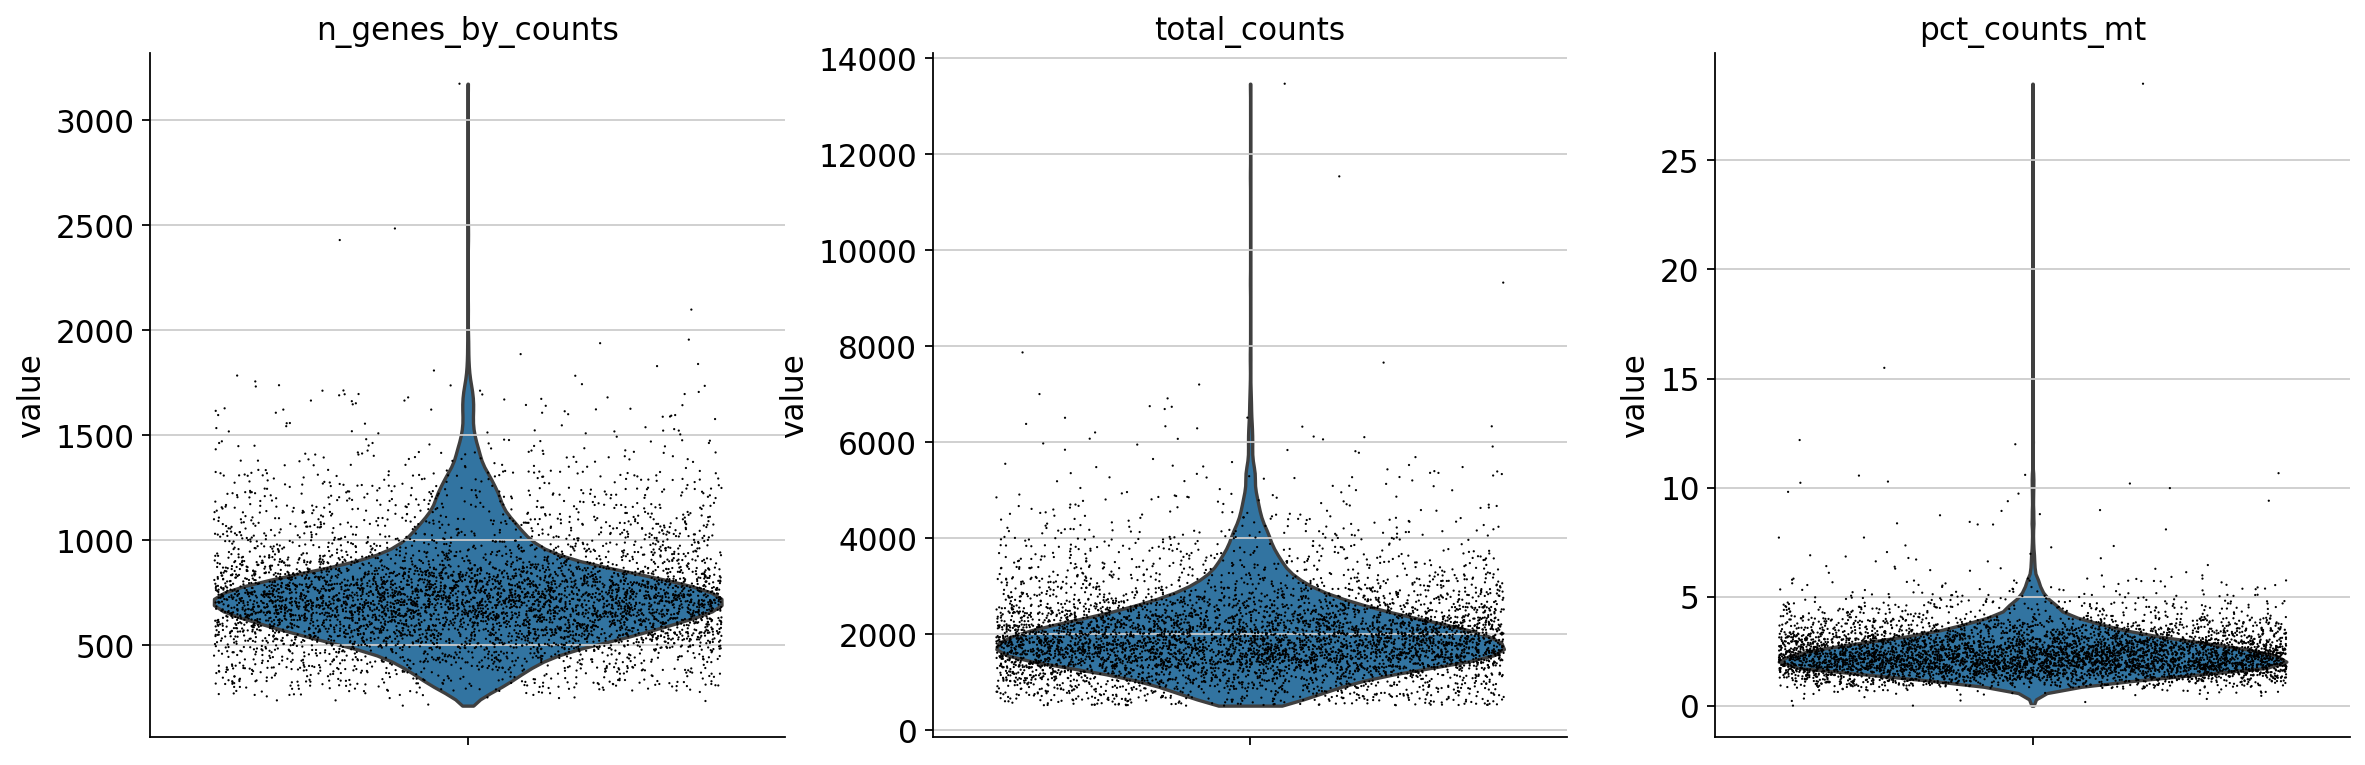

In [7]:
# remove genes with high mitochondrial content
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

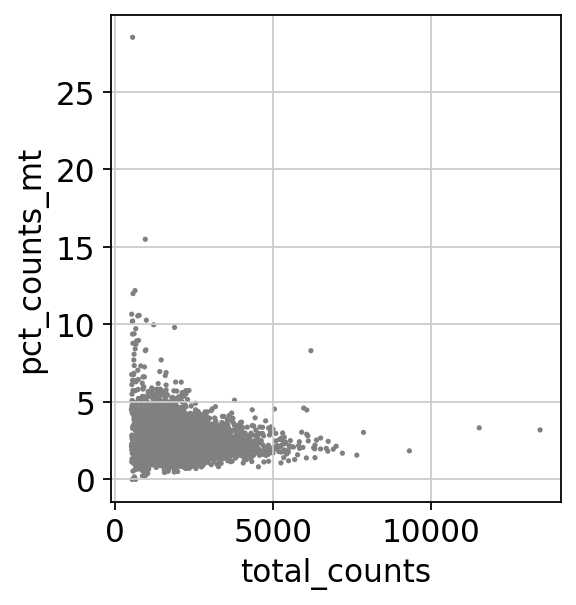

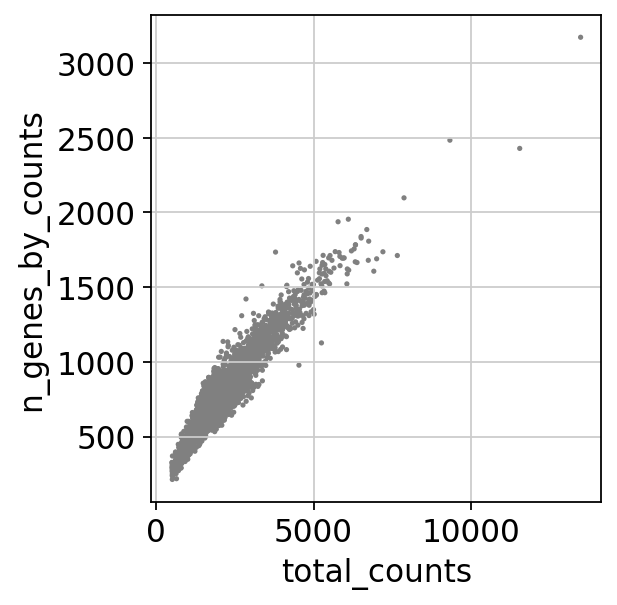

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [9]:
# slice the data based on the plots from above
# remove cells with more than 2500 genes
# remove cells with more than 5% MTgenes
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


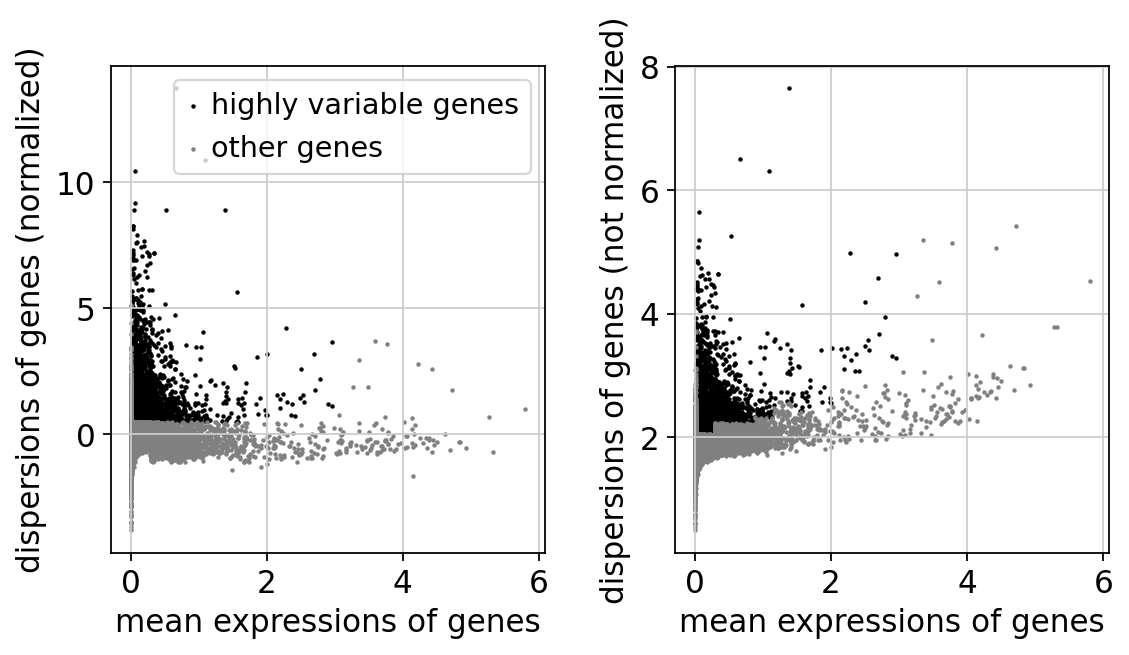

In [10]:
# normalize to 10K counts per cell
sc.pp.normalize_total(adata, target_sum=1e4)

# log data
sc.pp.log1p(adata)

# get high variance genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

# and plot
sc.pl.highly_variable_genes(adata)

# now store the raw version of the data for our use later
adata.raw = adata
adata.write(results_file)



### Run celltypist

In [11]:
celltype_pred = celltypist.annotate(adata, model = model_str, majority_voting = True)

🔬 Input data has 5292 cells and 14343 genes
🔗 Matching reference genes in the model
🧬 1391 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Can not detect a neighborhood graph, construct one before the over-clustering


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50


OMP: Info #273: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


⛓️ Over-clustering input data with resolution set to 10


running Leiden clustering
    finished: found 158 clusters and added
    'over_clustering', the cluster labels (adata.obs, categorical) (0:00:01)


🗳️ Majority voting the predictions
✅ Majority voting done!


In [12]:
celltype_pred.predicted_labels.value_counts()

predicted_labels                over_clustering  majority_voting               
Non-classical monocytes         0                Non-classical monocytes           180
CD16+ NK cells                  1                CD16+ NK cells                    159
Tem/Effector cytotoxic T cells  2                Tem/Effector cytotoxic T cells    108
B cells                         4                B cells                            92
Classical monocytes             3                Classical monocytes                92
                                                                                  ... 
Tem/Effector cytotoxic T cells  36               Non-classical monocytes             1
Helper T cells                  99               Tem/Effector helper T cells         1
Tem/Effector cytotoxic T cells  42               T cells                             1
                                47               Tem/Effector helper T cells         1
B cells                         2                T

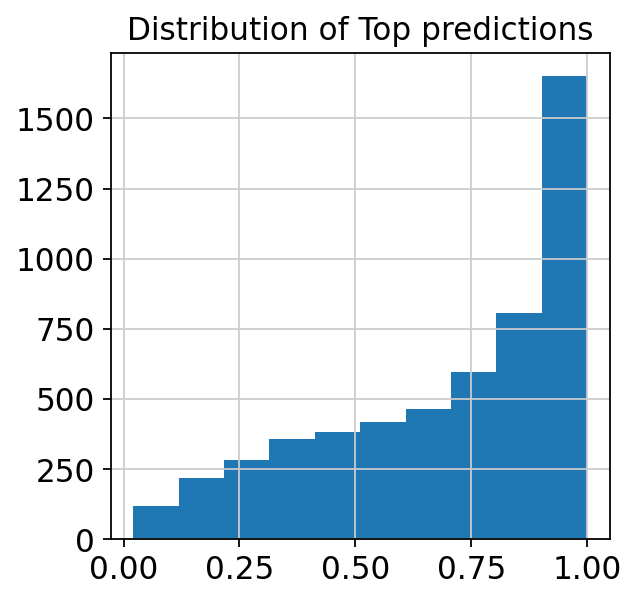

In [13]:
from matplotlib import pyplot as plt 
import numpy as np  

maxValues = celltype_pred.probability_matrix.max(axis = 1)
hist, bins = np.histogram(maxValues)
plt.hist(maxValues, bins = bins) 
plt.title("Distribution of Top predictions") 
plt.show()

In [14]:
# now process the counts further for doing DE 
# analysis and the cell clustering
adata = celltype_pred.to_adata()
adata = adata[:, adata.var.highly_variable]

# regress out the signal
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# scale the genes
sc.pp.scale(adata, max_value=10)


regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:01:08)


## PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


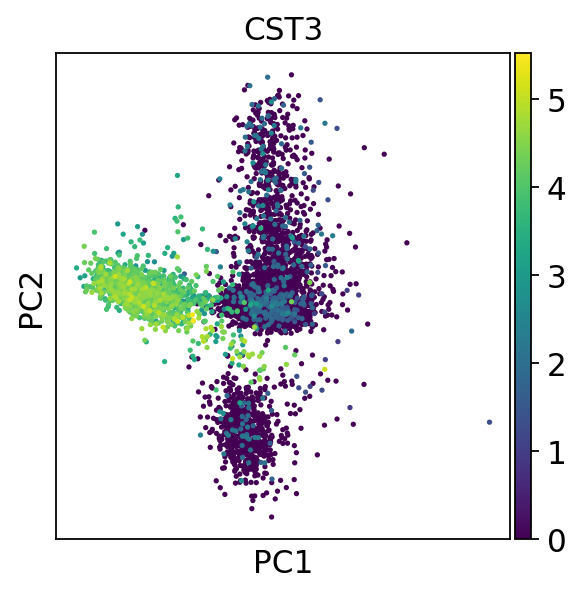

In [15]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')


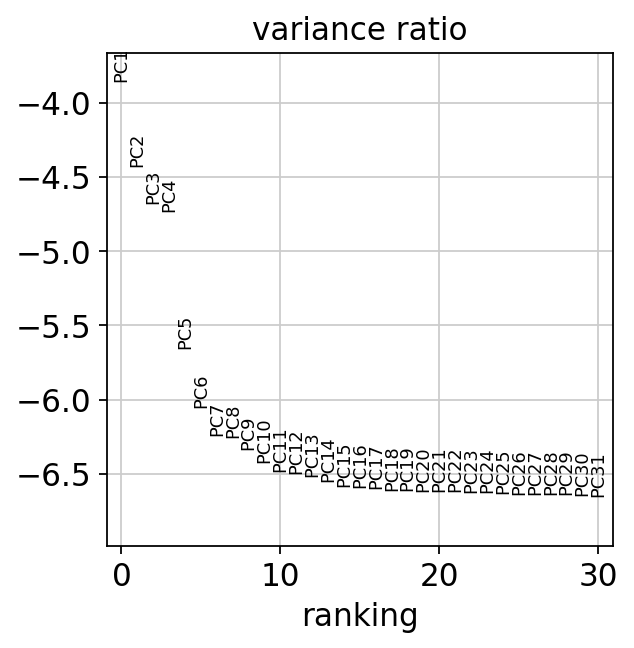

In [16]:
sc.pl.pca_variance_ratio(adata, log=True)


In [17]:
# save results
adata.write(results_file)


## Compute and embed neighborhood graph

In [18]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)


computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


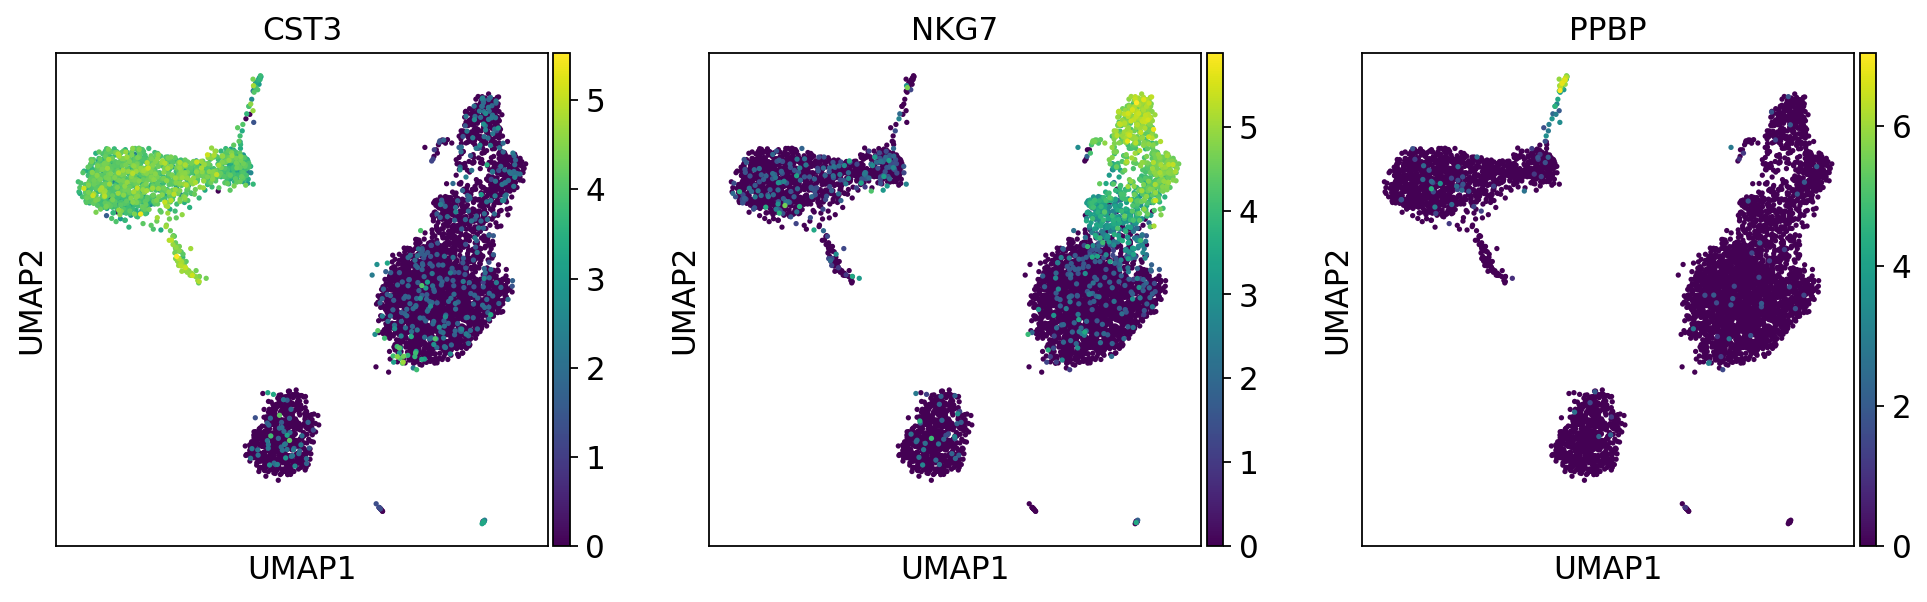

In [19]:
# plot some markers of the RAW data
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])


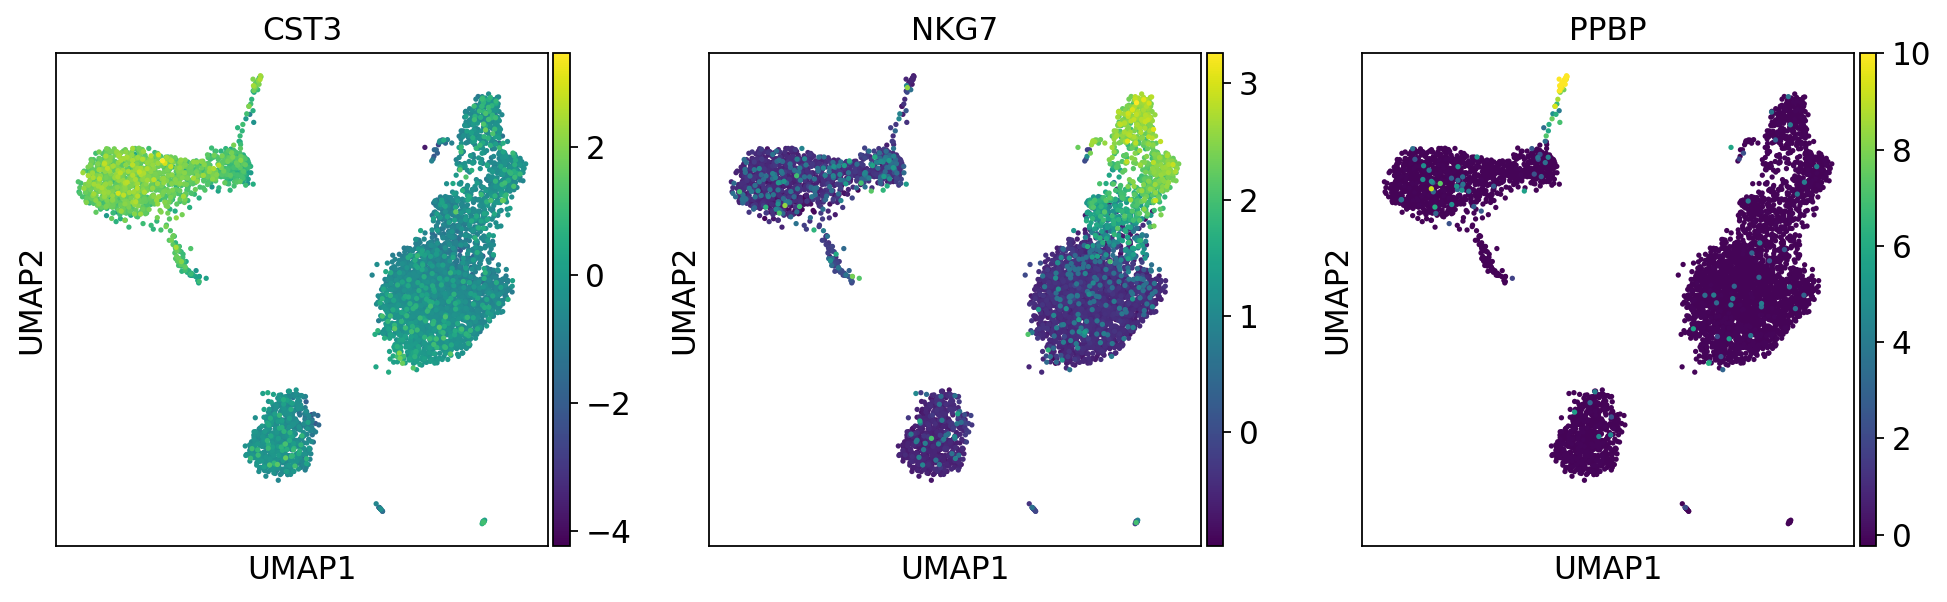

In [20]:
# now plot the corrected version (scaled+regressed)
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)


## Cluster the neighborhood graph

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


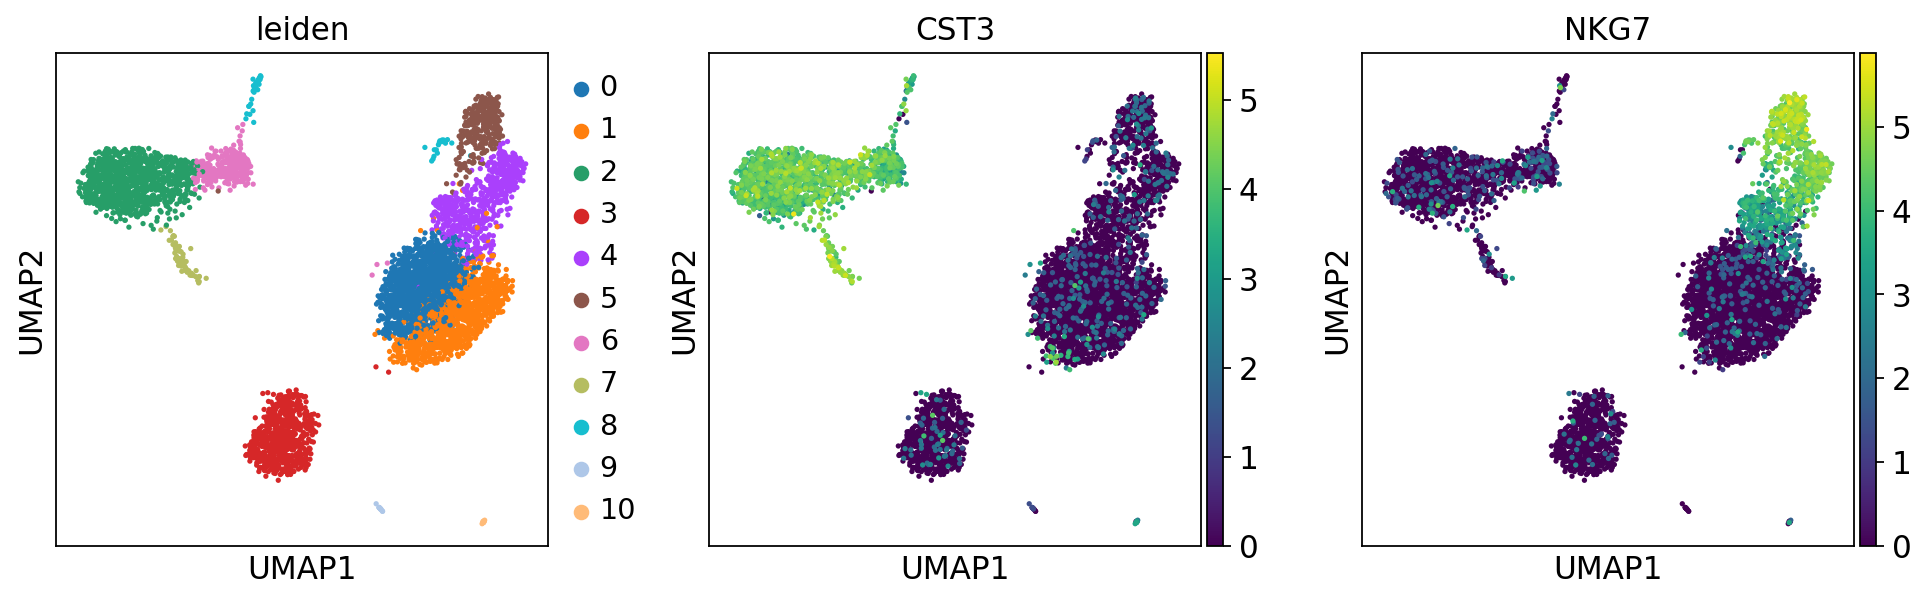

In [21]:
# lets use Leiden clustering
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])

# save
adata.write(results_file)


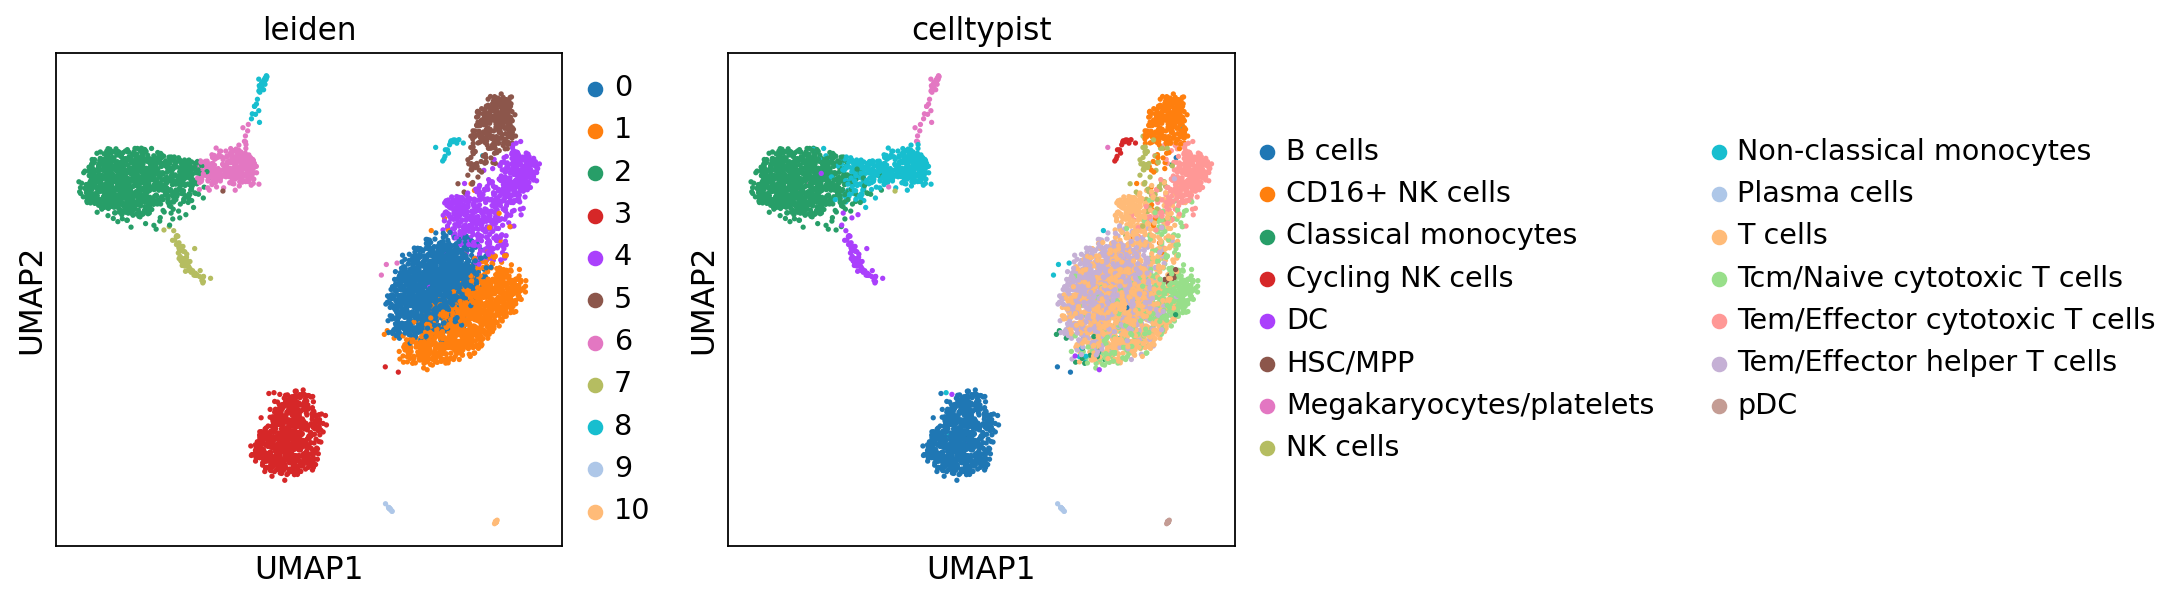

In [22]:
adata.obs['leiden']
adata.obs['celltypist'] = celltype_pred.predicted_labels['majority_voting']
sc.pl.umap(adata, color=['leiden', 'celltypist'])


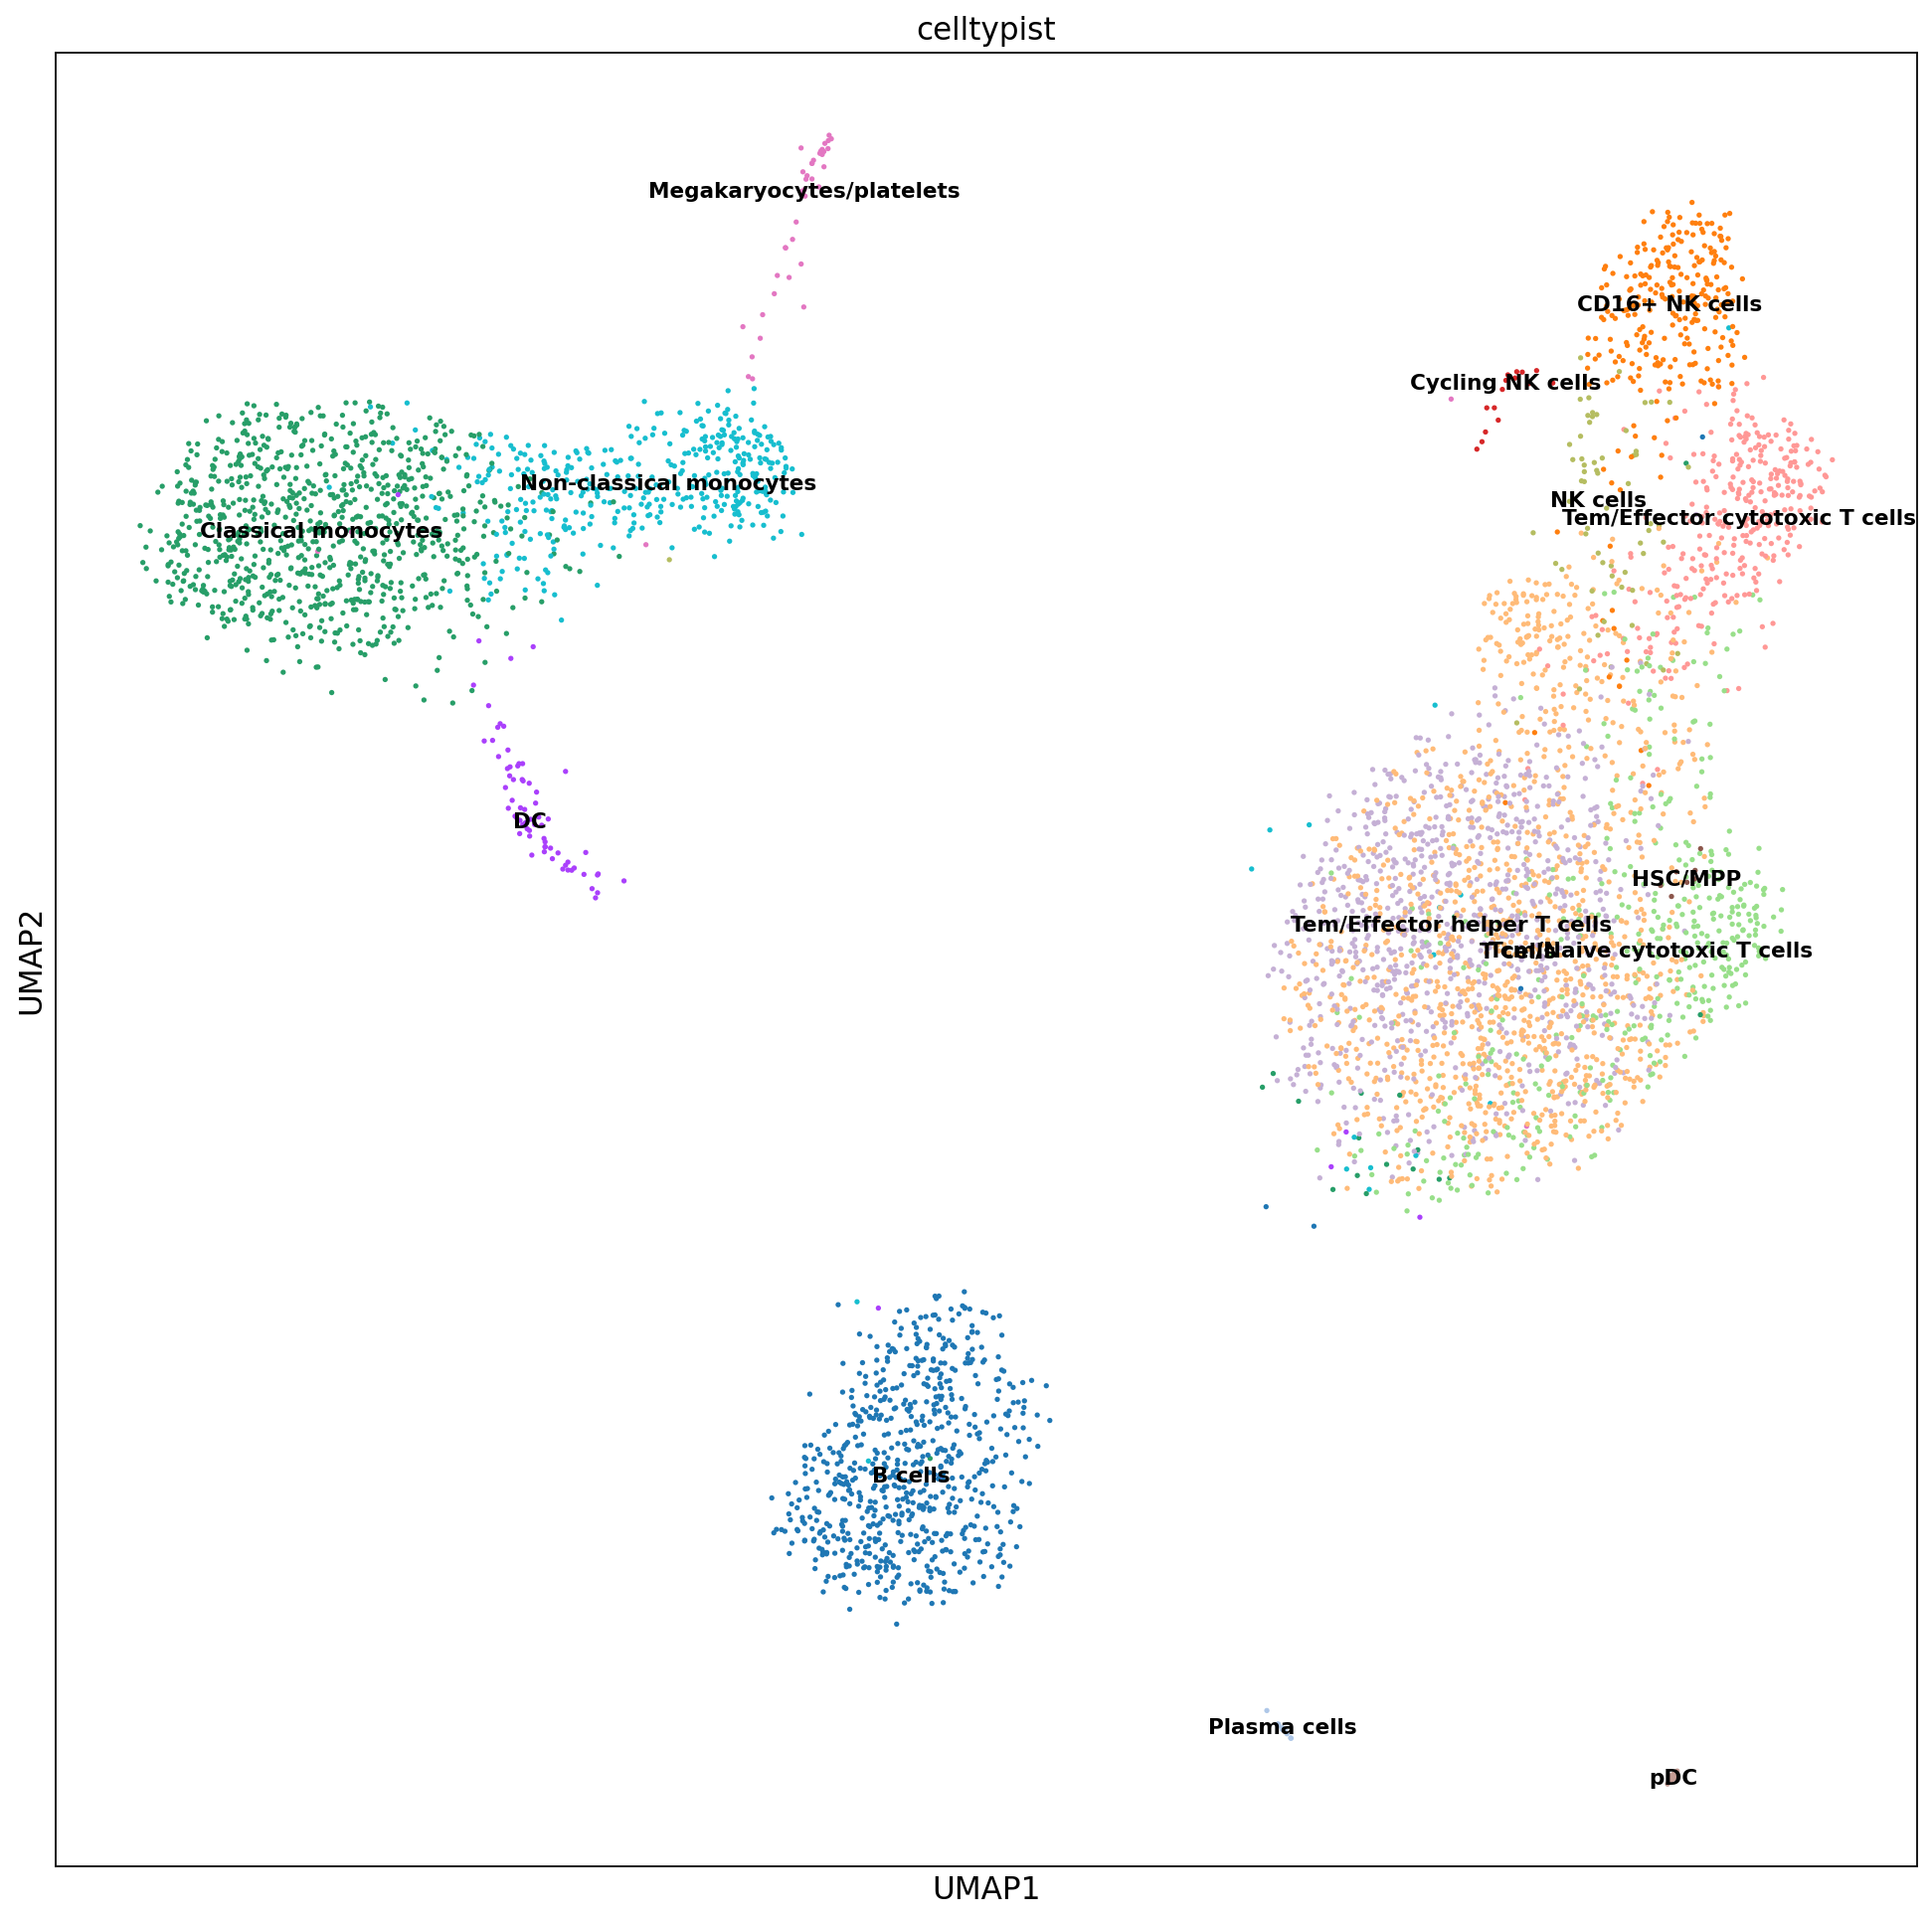

In [23]:
plt.rcParams['figure.figsize'] = [15, 15]
sc.pl.umap(adata, color=['celltypist'], legend_loc='on data', legend_fontsize="x-small")
